In [1]:
import numpy as np
from scipy.constants import c
from tqdm.notebook import tqdm
import h5py as hp
import matplotlib.pyplot as plt
from aps_figures.aps_one_column import *
from FITX import fit_risetime
from machine_data.TDR2 import *
from postprocessing import *
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from machine_data.soleil import v2366, v2366_v2

In [2]:
ring2 = v2366(IDs='closed', load_lattice=False)
chro = [1.6, 1.6]
ring = Synchrotron(h=ring2.h, optics=ring2.optics, particle=Electron(), L=ring2.L, E0=ring2.E0, ac=ring2.ac, 
                   U0=ring2.U0, tau=ring2.tau, emit=ring2.emit, tune=ring2.tune, 
                   sigma_delta=ring2.sigma_delta, sigma_0=ring2.sigma_0, chro=chro)
Q_S = ring.synchrotron_tune(1.8e6)
ring.emit

array([8.44e-11, 8.44e-12])

In [54]:
%matplotlib inline
n_macroparticles=1e6
n_turns = 7e4 #5e4
n_bin = 100
bunch_current = 1.2e-3
Qp_x = 1.6
Qp_y = 1.6 #np.linspace(0.1, 5.0, 50)

ID_state = 'close'
Zlong='True'
cavity='False'
tmci_current = 1e-3*np.linspace(0.1, 5, 50)
# tmci_current  = 1e-3*np.linspace(0.2, 10, 50)
risetimes = []
peak_freqsarr = []
peak_ampsarr = []
sigmas_dp = []
sigmas_dp_min = []
sigmas_dp_max = []

sigmas_z = []

# for Qp in tqdm(Qp_y):
for bunch_current in tqdm(tmci_current):
    risetime, peak_freqs, peak_amps, final_energy_offset, max_energy_offset, min_energy_offset, final_bunch_length = post_single(n_macroparticles,
                n_turns, 
                n_bin,
                bunch_current, 
                Qp_x,
                Qp_x,
                ID_state,
                Zlong,
                cavity)
    risetimes.append(risetime)
    peak_freqsarr.append(peak_freqs)
    peak_ampsarr.append(peak_amps)
    sigmas_dp.append(final_energy_offset)
    sigmas_z.append(final_bunch_length)    
    sigmas_dp_min.append(min_energy_offset)
    sigmas_dp_max.append(max_energy_offset)
    
# results = post_bunch_current_scan(n_macroparticles=1e6,
                                     # n_turns=1e5,
                                     # n_bin=100,
                                     # bunch_current_min=.1e-3,
                                     # bunch_current_max=5e-3, 
                                     # n_points=50)

  0%|          | 0/50 [00:00<?, ?it/s]

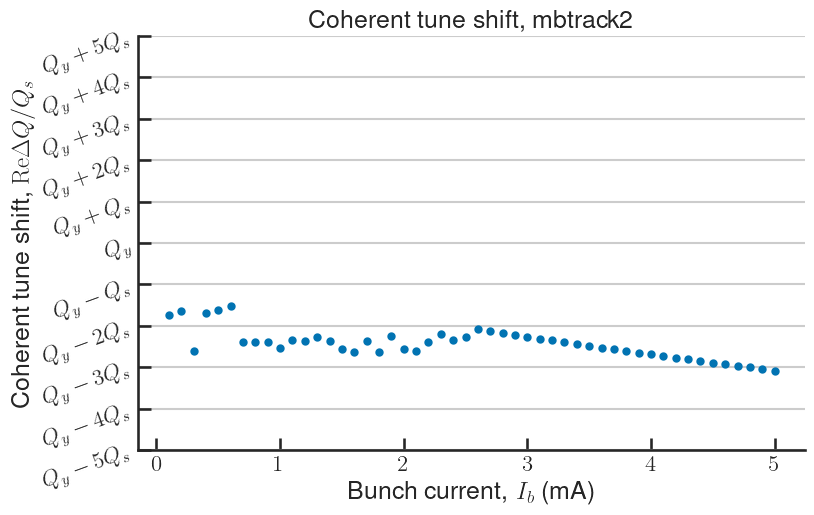

In [55]:
fig, ax = plt.subplots(1, 1)
# tmci_current = 1e-3*Qp_y

for i, I in enumerate(tmci_current/1e-3):
    for peak_freq in peak_freqsarr[i][:1]:
        ax.scatter(I, peak_freq, marker='.', color='b')
# ax.set_ylim((ring.tune[1]-np.floor(ring.tune[1])-5*Q_S)/Q_S, (ring.tune[1]-np.floor(ring.tune[1])+Q_S)/Q_S)
multiple_of = 5
Q_S = 2.1e-3
Q_Y = ring.tune[1]
ax.set_ylim(Q_Y-np.floor(Q_Y)-multiple_of*Q_S, Q_Y-np.floor(Q_Y)+multiple_of*Q_S)
ax.set_yticks(np.linspace(Q_Y-np.floor(Q_Y)-multiple_of*Q_S, Q_Y-np.floor(Q_Y)+multiple_of*Q_S, 2*multiple_of+1))
labels = ['$Q_y-Q_s$', '$Q_y$', '$Q_y+Q_s$']
for i in range(2, multiple_of+1):
    labels.insert(0, '$Q_y-{:}Q_s$'.format(i))
    labels.append('$Q_y+{:}Q_s$'.format(i))
ax.set_yticklabels(labels, rotation = 20)
ax.yaxis.grid(True)
ax.set_xlabel('Bunch current, $I_b$ (mA)')
ax.set_ylabel('Coherent tune shift, $\mathrm{Re}\Delta Q/Q_s$')
ax.title.set_text('Coherent tune shift, mbtrack2')
# plt.savefig('mbtrack_coherent_Qb_HC.svg')

[0.03495478 0.01898534 0.02204046]


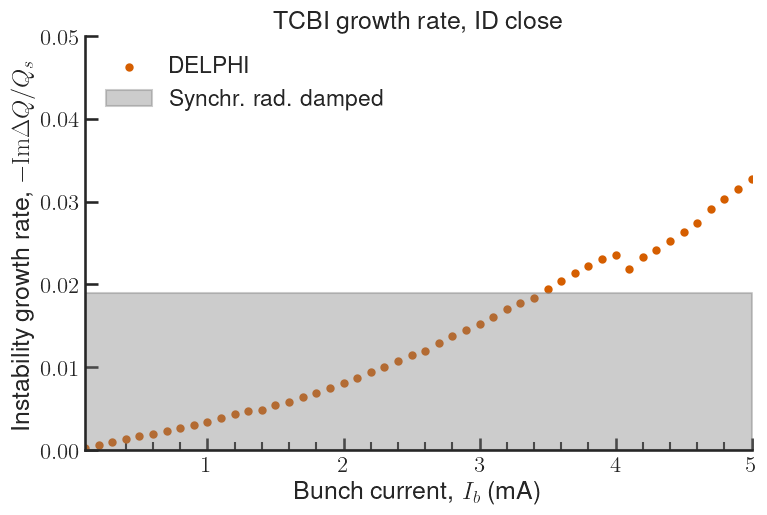

In [69]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pandas as pd
folder = '/home/gubaidulin/scripts/analytical/delphi/'
filename = folder+'delphi(taub=2.0e-10,ID=close,plane=vertical,Qp=1.6,M=1,Q_s=7.0e-04,n_max=0).csv'
Q_S = .7e-3
datafr = pd.read_csv(filename, sep='\t')
fig, ax = plt.subplots(1, 1)
# ax.plot(tmci_current/1e-3, (2*np.pi*np.array(risetimes))**-1/Q_S, marker='.', label='mbtrack2')
for Qp in datafr['BunchCurrent'].drop_duplicates():
    k=1
    label = 'DELPHI' if Qp == datafr['BunchCurrent'][0] else None 
    index = datafr['BunchCurrent']==Qp
    ax.scatter(datafr[index]['BunchCurrent'][:k]/1e-3,
           -datafr[index]['eigvals_im'][:k]/Q_S,
            marker='.',
            color='r',
          label=label)
ax.set_xlim(min(tmci_current)/1e-3, max(tmci_current)/1e-3)
ax.set_ylim(0, .05)

dQrad = (2*np.pi*ring.tau[1]*ring.f0)**(-1)
print((2*np.pi*ring.tau*ring.f0)**(-1)/Q_S)
# dQdamp = (2*np.pi*50)**(-1)
ax.fill_between(tmci_current/1e-3, dQrad/Q_S, 0, color='grey', alpha=0.4, label='Synchr. rad. damped')
# ax.fill_between(tmci_current/1e-3, dQdamp/Q_S, 0, color='navy', alpha=0.4, label='FBT?')
ax.xaxis.set_minor_locator(MultipleLocator(.2))
ax.title.set_text('TCBI growth rate, ID close')
ax.set_xlabel('Bunch current, $I_b$ (mA)')
ax.set_ylabel('Instability growth rate, $-\mathrm{Im}\Delta Q/Q_s$')
plt.legend(loc='upper left')
# plt.savefig('/home/gubaidulin/Pictures/work/TMCI/head_tail_HC_close.svg')

(0.0, 5.0)

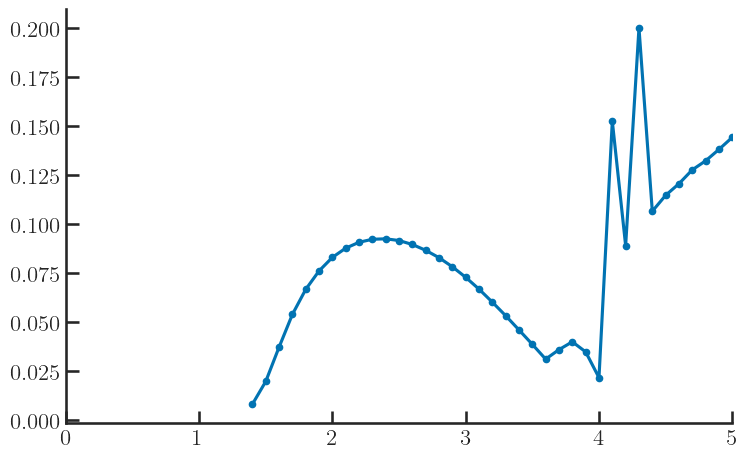

In [11]:
fig, ax = plt.subplots(1, 1)
# ax.plot(tmci_current/1e-3, np.array(sigmas_z)/1e-12)
ax.plot(tmci_current/1e-3,
        (2*np.pi*np.array(risetimes))**-1/Q_S,
        marker='.')
ax.set_xlim(0, max(tmci_current)/1e-3)
# ax.plot(tmci_current/1e-3, np.array(sigmas_dp)*1e2, marker='.')
# ax.axhline(ring.sigma_delta*1e2, linestyle='dashed')
# ax.fill_between(tmci_current/1e-3, 1e2*np.array(sigmas_dp_min), 1e2*np.array(sigmas_dp_max), color='b', alpha=0.5)

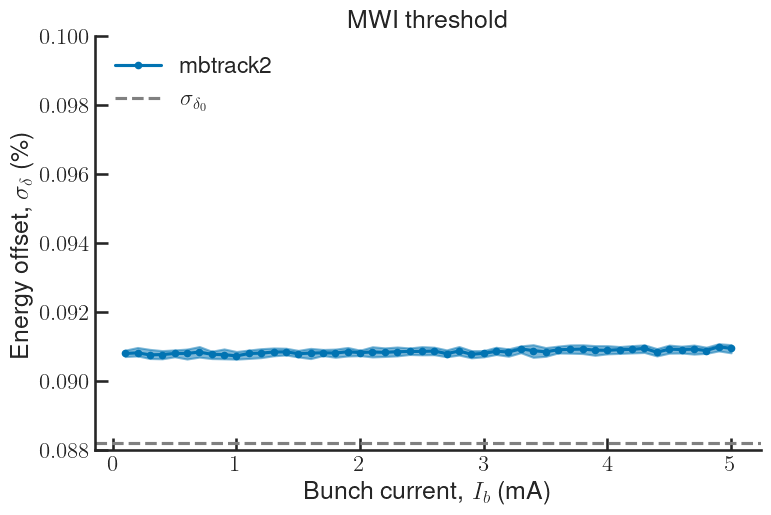

In [35]:
fig, ax = plt.subplots(1, 1)
# tmci_current = 1e-3*np.linspace(0.1, 5, 50)
# sigmas_dp = results['FinalEnergyOffset'][:]
ax.plot(tmci_current*1e3, np.array(sigmas_dp)*1e2, marker='.', label='mbtrack2')
# ax.fill_between(tmci_current*1e3, results['MaxEnergyOffset'][:]*1e2, results['MinEnergyOffset'][:]*1e2, alpha=0.5, color='b')
ax.fill_between(tmci_current*1e3, np.array(sigmas_dp_min)*1e2, np.array(sigmas_dp_max)*1e2, alpha=0.5, color='b', label=None)
sigma_delta = 0.000882
ax.axhline(sigma_delta*1e2, linestyle='dashed', color='grey', label='$\sigma_{\delta_0}$')
ax.set_ylim(0.088, 0.1)
ax.title.set_text('MWI threshold')
ax.set_xlabel('Bunch current, $I_b$ (mA)')
ax.set_ylabel('Energy offset, $\sigma_\delta$ (\%)')
plt.legend(loc='upper left')
plt.savefig('/home/gubaidulin/Pictures/work/TMCI/mwi_HC.svg')

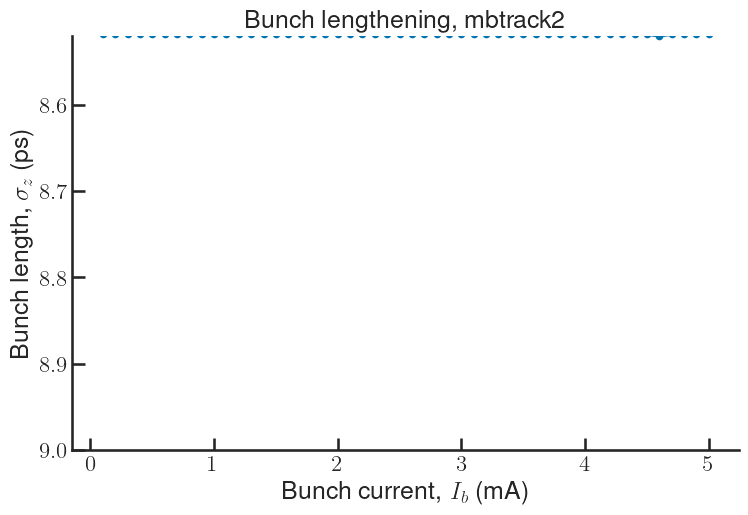

In [12]:
fig, ax = plt.subplots(1, 1)
# sigmas_z = results['FinalBunchLength'][:]
ax.plot(tmci_current*1e3, np.array(sigmas_z)/1e-12, marker='.')
# np.save('sigmas_HC.npy', np.array(sigmas_z))
ax.set_ylim(ring.sigma_0/1e-12)
ax.set_xlabel('Bunch current, $I_b$ (mA)')
ax.set_ylabel('Bunch length, $\sigma_z$ (ps)')
ax.title.set_text('Bunch lengthening, mbtrack2')
plt.savefig('bunch_lengthening_HC.svg')

Text(0, 0.5, 'Coherent betatron tune, $Q_b$')

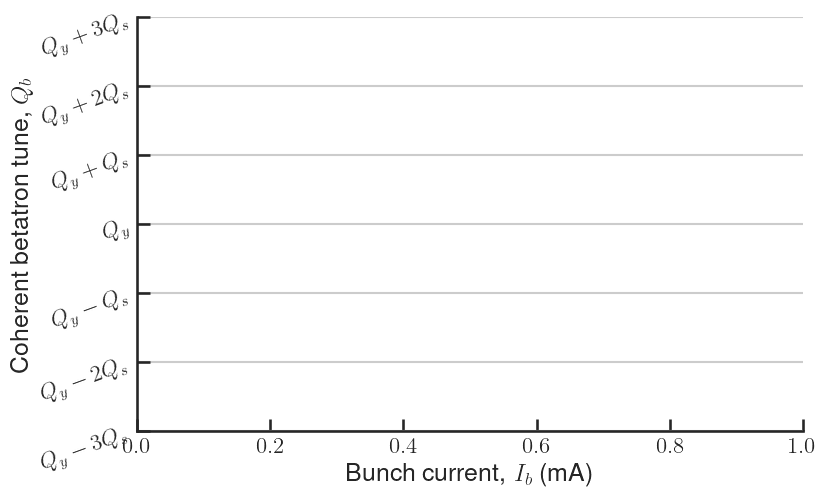

In [13]:
fig, ax = plt.subplots(1, 1)
for i, peak_freq in enumerate(peak_freqs):
    for p in peak_freq:
        ax.scatter(tmci_current[i]/1e-3, p, marker='.', color='black',)# alpha=peak_amps[i][p])
    
multiple_of=3
ax.set_ylim(Q_Y-np.floor(Q_Y)-multiple_of*Q_S, Q_Y-np.floor(Q_Y)+multiple_of*Q_S)
ax.set_yticks(np.linspace(Q_Y-np.floor(Q_Y)-multiple_of*Q_S, Q_Y-np.floor(Q_Y)+multiple_of*Q_S, 2*multiple_of+1))
labels = ['$Q_y-Q_s$', '$Q_y$', '$Q_y+Q_s$']
for i in range(2, multiple_of+1):
    labels.insert(0, '$Q_y-{:}Q_s$'.format(i))
    labels.append('$Q_y+{:}Q_s$'.format(i))
ax.set_yticklabels(labels, rotation = 20)
# ax.title.set_text('Coherent betatron tune')
ax.yaxis.grid(True)
ax.set_xlabel('Bunch current, $I_b$ (mA)')
ax.set_ylabel('Coherent betatron tune, $Q_b$')

In [46]:
folder = '/home/gubaidulin/scripts/tracking/Results/new/'
# folder = '/home/gubaidulin/scripts/tracking/Results/IDsopen/tmci_scan/'
n_macroparticles = 1e6
n_bin = 100
bunch_current = 1.2e-3
Qp_x = 0.0
Qp_y = 0.0
# n_turns = 1e5
n_turns = 7.5e4
# n_turns = 2e5
# n_turns = 5e4
id_state='open'
Zlong='True'
cavity='True'
filename = folder+'monitors(n_mp={:.1e},n_turns={:.1e},n_bin={:},bunch_current={:.1e},Qp_x={:.2f},Qp_y={:.2f},ID_state={:},Zlong={:},cavity={:})'.format(
                                                                                                                        n_macroparticles,
                                                                                                                        n_turns, 
                                                                                                                        n_bin,
                                                                                                                        bunch_current, 
                                                                                                                        Qp_x,
                                                                                                                        Qp_y,
                                                                                                                        id_state,
                                                                                                                        Zlong,
                                                                                                                        cavity
)
# filename = folder+'monitors(n_mp={:.1e},n_turns={:.1e},n_bin={:},bunch_current={:.1e},Qp_x={:.2f},Qp_y={:.2f})'.format(
#                                                                                                                         n_macroparticles,
#                                                                                                                         n_turns, 
#                                                                                                                         n_bin,
#                                                                                                                         bunch_current, 
#                                                                                                                         Qp_x,
#                                                                                                                         Qp_y,
# )
with hp.File(filename+'.hdf5') as f:
    print(f.keys())
    print(f['BunchData_0'].keys())
    print(f['WakePotentialData_0'].keys())
    m = f['BunchData_0']['mean'][:]
    std = f['BunchData_0']['std'][:]
    J = f['BunchData_0']['cs_invariant'][:]
    emit = f['BunchData_0']['emit'][:]
    p = f['WakePotentialData_0']['profile_Wydip'][:]
    tau = f['WakePotentialData_0']['tau_Wydip'][:]
    dip = f['WakePotentialData_0']['dipole_Wydip'][:]

<KeysViewHDF5 ['BunchData_0', 'WakePotentialData_0']>
<KeysViewHDF5 ['cs_invariant', 'current', 'emit', 'mean', 'std', 'time']>
<KeysViewHDF5 ['Wydip', 'dipole_Wydip', 'profile_Wydip', 'tau_Wydip', 'time']>


/home/gubaidulin/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


R-squared is 0.97415


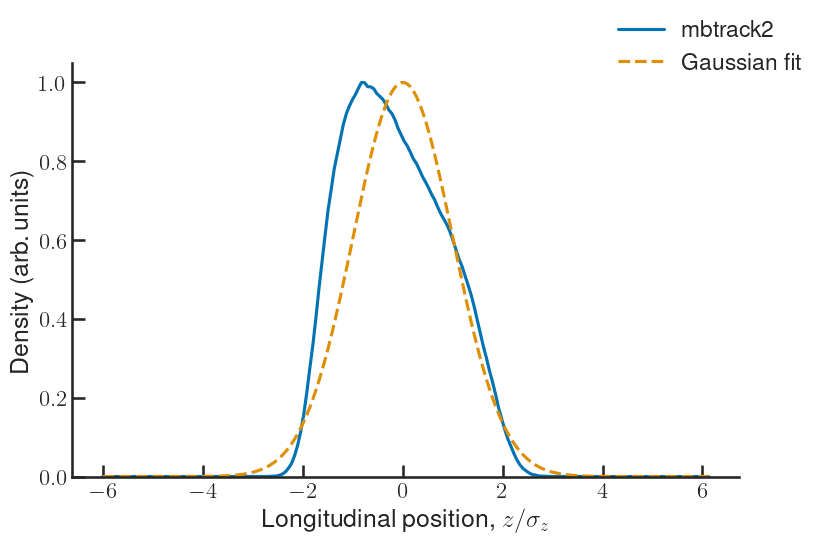

In [47]:
%matplotlib inline
from utils import *
from scipy.interpolate import interp1d


t = tau[:, 0]/std[4, 20000]
p_norm = p[:, 0]/np.max(p[:,0])
t0 = np.linspace(-5, 5, 5000)
interp_fit = interp1d(t, p_norm)
# r2, popt = fit_loop(t0, interp_fit(t0))
fig, ax = plt.subplots(1, 1)
ax.plot(t, p_norm, label='mbtrack2')
plt.plot(t, np.exp(-.5*t**2), linestyle='dashed', label='Gaussian fit')
# ax.plot(t0, laguerre_fit(t0, *popt), linestyle='dashdot', label='Laguerre fit')
ax.set_xlabel('Longitudinal position, $z/\sigma_z$')
ax.set_ylabel('Density (arb.\,units)')

# ax.set_xlim(-4, 4)
ax.set_ylim(0, )
plt.figlegend()
print("R-squared is {:.5f}".format(r2))
plt.savefig('/home/gubaidulin/Pictures/work/TMCI/long_progile_HC.svg')

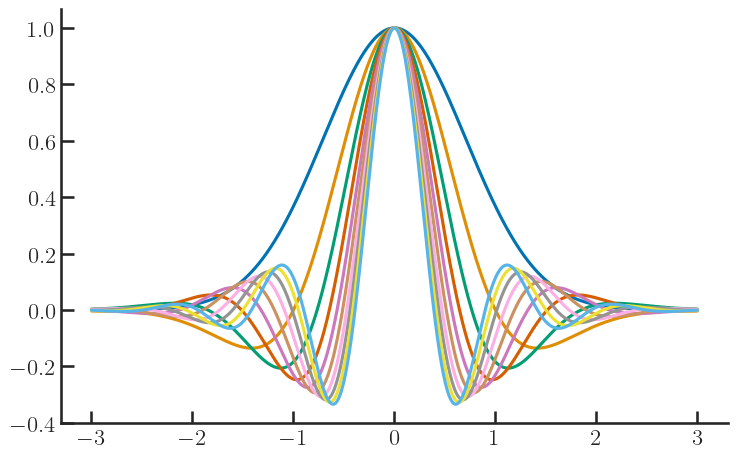

In [49]:
from scipy.special import genlaguerre
for order in range(0, 10):
    x = np.linspace(-3, 3, 1000)
    y = np.exp(-x**2)*genlaguerre(order, 0)(x**2)
    plt.plot(x, y)

(200, 2400)
(200, 2400)


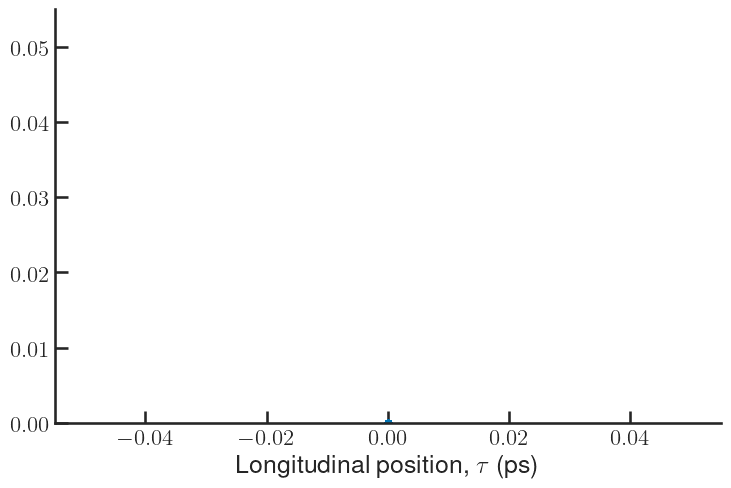

In [50]:
from aps_figures.aps_one_column import *
fig, ax = plt.subplots(1,1)
print(tau.shape)
print(p.shape)
# ax.plot(tau[:,2000]/std[4,0], p[:,100])
# turn_considered = 0
ax.plot(tau[:, 1000]/1e-12, p[:, 1000]/np.max(p[:, 0]), marker='.')
ax.set_xlabel('Longitudinal position, $\\tau$ (ps)')
ax.set_ylim(0, )
# ax.plot(tau[:,turn_considered]/std[4,turn_considered], p[:,turn_considered])
# ax.set_xlim(-3, 3)
y = np.exp(-.5*(tau[:, -1]/(std[4,0]))**2)
ax.plot(tau[:, -1]/1e-12, y, linestyle='dashed')
# ax.axhline(ring.sigma_0/1e-12, color='gray', linestyle='dashed', label='')
# ax.set_ylabel('Bunch length, $\sigma_z$ (ps)')
# ax.set_xlabel('Time (turns)')
# ax.set_ylim(8, 25)
# ax.plot()
plt.savefig('bunch_profile_example.svg')

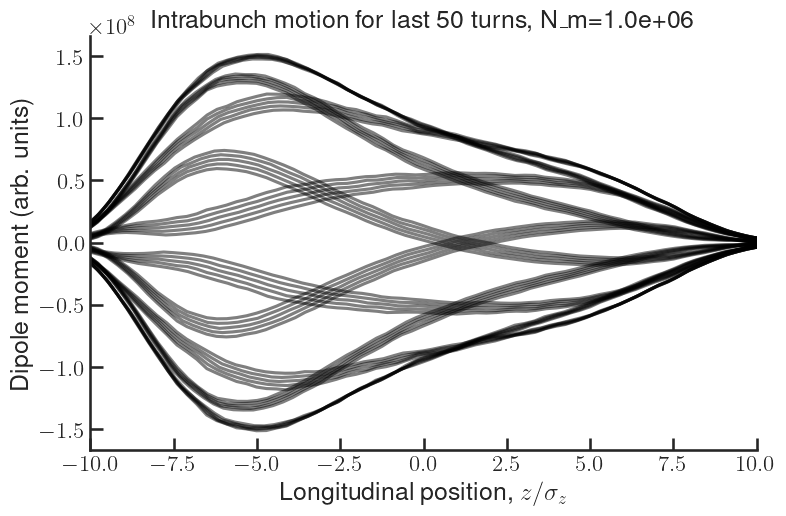

In [51]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
linenumber = 50
linestart = 50
lineend =100
# ax.plot((tau_y[:,-linenumber:])*c/SIGMA_Z, profile_y[:,-linenumber:], color='black', alpha=0.5)
ax.plot(tau[:,linestart:lineend]*c/SIGMA_Z, dip[:,linestart:lineend]*p[:,linestart:lineend], color='black', alpha=0.5)
ax.set_xlim(-10, 10)
ax.set_xlabel('Longitudinal position, $z/\sigma_z$')
ax.set_ylabel('Dipole moment (arb. units)')
ax.title.set_text('Intrabunch motion for last {:} turns, N_m={:.1e}'.format(linenumber, n_macroparticles))
plt.savefig(FOLDER_FIG+'intrabunch_motion(Qp_y={:}).pdf'.format(Qp_y))

0.0021
Coherent synchrotron tune is 0.0007
8.626326228252765


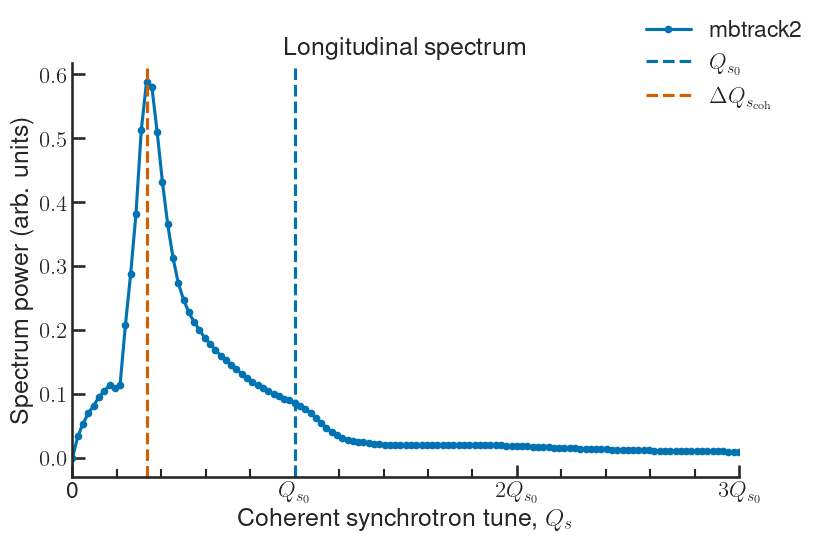

In [52]:
%matplotlib inline
from scipy.signal import find_peaks
from matplotlib.ticker import AutoMinorLocator


fftz = np.abs(np.fft.rfft(m[5,:20000]-np.mean(m[5,:20000])))
fftfreqz = np.fft.rfftfreq(m[5,:20000].shape[0])
Q_S = 2.1e-3
fig, ax = plt.subplots(1, 1)
ax.plot(fftfreqz, fftz, marker='.', label='mbtrack2')
ax.axvline(Q_S, linestyle='dashed', label='$Q_{s_0}$')
print(Q_S)
ax.set_ylabel('Spectrum power (arb. units)')
ax.set_xlabel('Coherent synchrotron tune, $Q_s$')
ax.title.set_text('Longitudinal spectrum')
find_peaks(fftz)[0].shape
Q_coh = fftfreqz[find_peaks(fftz)[0][1]]
ax.axvline(Q_coh, linestyle='dashed', color='r', label='$\Delta Q_{s_\mathrm{coh}}$')
print('Coherent synchrotron tune is {:}'.format(Q_coh))

ax.set_xticks([0, Q_S, 2*Q_S, 3*Q_S])
ax.set_xticklabels(['0', '$Q_{s_0}$', '$2Q_{s_0}$', '$3Q_{s_0}$'])
ax.set_xlim(0, 3*Q_S)
# ax.set_ylim(0, 5e-8)
minor_locator = AutoMinorLocator(5)
ax.xaxis.set_minor_locator(minor_locator)
# plt.savefig(FOLDER_FIG+'synchrotron_tune(Qp_y={:}).pdf'.format(int(Qp_y)))
plt.figlegend()
plt.savefig('/home/gubaidulin/Pictures/work/TMCI/Q_s_HC.svg')
print(std[4,0]/1e-12)

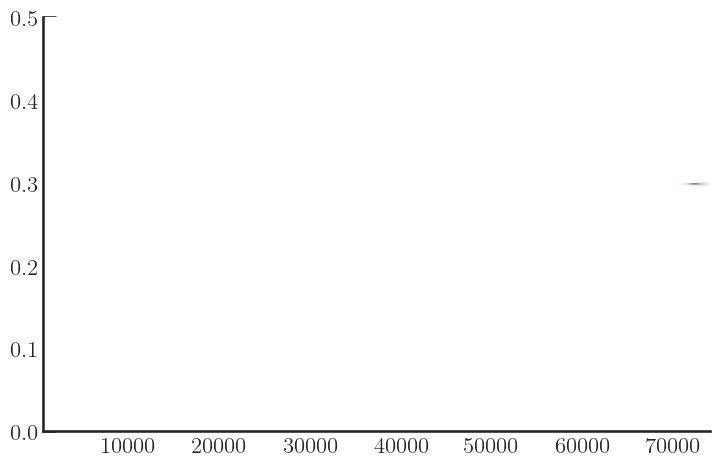

In [76]:
%matplotlib inline
from scipy.signal import spectrogram, medfilt
f, t, Sxx = spectrogram(m[2,:], fs=1, nperseg=1000)
fig, ax = plt.subplots(1, 1)
ax.pcolormesh(t, f, Sxx, shading='gouraud', cmap='binary')
# ax.set_ylim(0, 5*Q_S)
# ax.set_yticks([0, Q_S, 2*Q_S, 3*Q_S, 4*Q_S, 5*Q_S])
# ax.set_yticklabels(['0', '$Q_s$', '$2Q_s$', '$3Q_s$', '$4Q_s$', '$5Q_s$'])
# ax.set_xlim(0, 20000)
# ax.set_ylim(Q_Y-np.floor(Q_Y)-3*Q_S, Q_Y-np.floor(Q_Y)+3*Q_S)

[-1.26423550e-09  9.80871268e-10  6.54764320e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


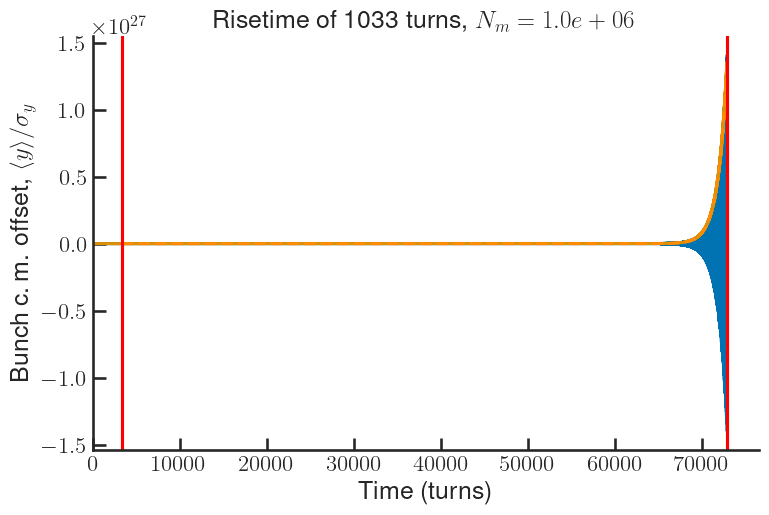

In [77]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
print(m[2,:])
ax.plot(np.trim_zeros(m[2,:], trim='b')/std[2, 0])
min_level = 0.02
signal = np.sqrt(np.trim_zeros(m[2,:], trim='b')**2+(BETA_Y_SMOOTH*np.trim_zeros(m[3,:], trim='b'))**2)/std[2,0]
smoothing_window_size = 50
risetime = fit_risetime(signal,
                      min_level=min_level, 
                      smoothing_window_size=smoothing_window_size,
                      matplotlib_axis=ax)
ax.set_xlabel('Time (turns)')
ax.set_ylabel('Bunch c.\,m. offset, $\langle y \\rangle/\sigma_y$')
ax.set_xlim(0, )
# ax.set_ylim(-.1, .1)
ax.title.set_text('Risetime of {:.0f} turns, $N_m={:.1e}$'.format(risetime, n_macroparticles))
# plt.savefig(FOLDER_FIG+'beam_offset(Qp_y={:}).pdf'.format(Qp_y))

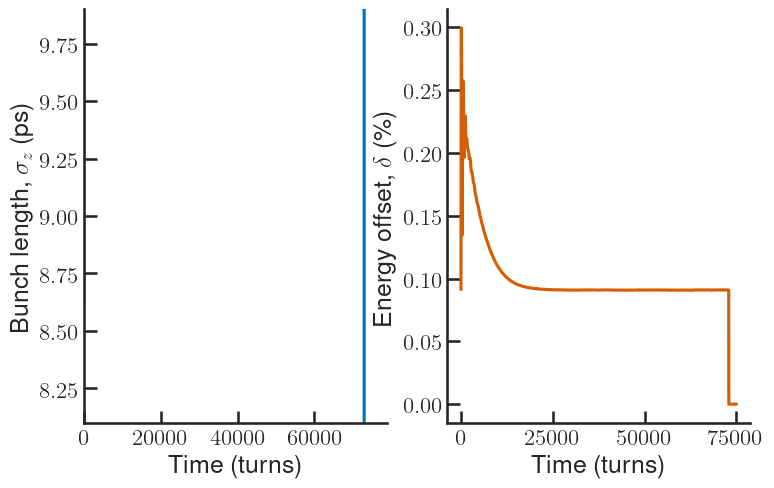

In [9]:
%matplotlib inline
from aps_figures.aps_one_column import *
fig, ax = plt.subplots(1, 2)
ax[0].plot(1e12*std[4, :], color='b')

ax[0].set_xlabel('Time (turns)')
ax[0].set_ylabel('Bunch length, $\sigma_z$ (ps)')
ax[0].set_xlim(0, )
ax[0].set_ylim(0.9*ring.sigma_0/1e-12, 1.1*ring.sigma_0/1e-12 )
# ax[0].axhline(8.52)
ax[1].plot(1e2*std[5,:], color='r')
ax[1].set_xlabel('Time (turns)')
ax[1].set_ylabel('Energy offset, $\delta$ (\%)')
# ax[0].set_ylim(.9*ring.sigma_0/1e-12, 1.1*ring.sigma_0/1e-12)
# ax[1].set_ylim(.9*ring.sigma_delta/1e-2, 1.1*ring.sigma_delta/1e-2)

# ax.title.set_text('Risetime of {:.1e} turns, $N_m={:.1e}$'.format(risetime, n_macroparticles))
# plt.savefig(FOLDER_FIG+'beam_offset(Qp_y={:}).pdf'.format(Qp_y))
plt.savefig('mwi_HC_example.svg')

['$Q_y-7Q_s$', '$Q_y-6Q_s$', '$Q_y-5Q_s$', '$Q_y-4Q_s$', '$Q_y-3Q_s$', '$Q_y-2Q_s$', '$Q_y-Q_s$', '$Q_y$', '$Q_y+Q_s$', '$Q_y+2Q_s$', '$Q_y+3Q_s$', '$Q_y+4Q_s$', '$Q_y+5Q_s$', '$Q_y+6Q_s$', '$Q_y+7Q_s$']


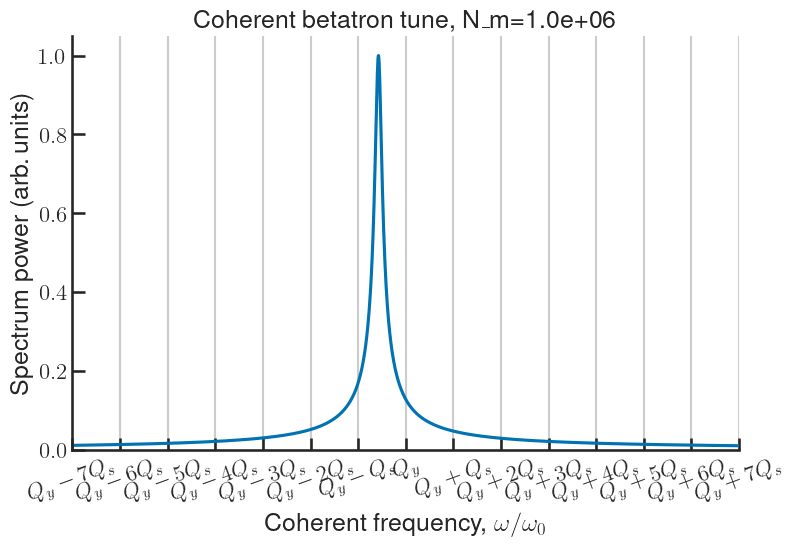

In [79]:
%matplotlib inline
from aps_figures.aps_one_column import *
ffty = np.abs(np.fft.rfft(m[2,:]))
fftfreqy = np.fft.rfftfreq(m[2,:].shape[0])
fig, ax = plt.subplots(1, 1)
ax.plot(fftfreqy, ffty/np.max(ffty))
# ax.set_xlim(0, 5e-3)
Q_S = 2.1e-3
multiple_of = 7
ax.set_xlabel('Coherent frequency, $\omega/\omega_0$')
ax.set_ylabel('Spectrum power (arb.\,units)')
ax.set_xlim(Q_Y-np.floor(Q_Y)-multiple_of*Q_S, Q_Y-np.floor(Q_Y)+multiple_of*Q_S)
ax.set_xticks(np.linspace(Q_Y-np.floor(Q_Y)-multiple_of*Q_S, Q_Y-np.floor(Q_Y)+multiple_of*Q_S, 2*multiple_of+1))
labels = ['$Q_y-Q_s$', '$Q_y$', '$Q_y+Q_s$']
for i in range(2, multiple_of+1):
    labels.insert(0, '$Q_y-{:}Q_s$'.format(i))
    labels.append('$Q_y+{:}Q_s$'.format(i))
print(labels)
ax.set_xticklabels(labels, rotation = 20)
ax.title.set_text('Coherent betatron tune, N_m={:.1e}'.format(n_macroparticles))
ax.xaxis.grid(True)
ax.set_ylim(0,)
# plt.savefig(FOLDER_FIG+'coherent_betatron_tune(Qp_y={:}).pdf'.format((Qp_y)))
peaks = find_peaks(ffty/np.max(ffty), height=0.1, distance=20)
# print(fftfreqy[peaks[0]])
# print(ffty[peaks[0]])
# import PyNAFF as pnf
# n = pnf.naff(m[2,:], turns=m[2,:].shape[0], nterms=500, skipTurns=0, getFullSpectrum=False, window=1)
# for p in fftfreqy[peaks[0]]:
    # plt.axvline(p)

In [100]:
print(1/Q_S)

476.1904761904762
